# Prediction Foot Project
Lorrain MORLET - Julien DE VOS


## Introduction

To introduce the prediction soccer contest, we aim to develop an AI model that can predict the outcome of soccer matches. The goal is to analyze historical data and identify patterns that can help us make accurate predictions.

The final objective of the project is to predict the outcome of Ligue 1 matches for the 2023-2024 season. To do this, we have access to data on Ligue 1 matches from the 2012-2013 season to the 2022-2023 season.

In this test, we will use some dataset containing information about various soccer matches, including team statistics, player performance, player appearance. Our objective is to train a machine learning model that can classify the result of a match as a win, loss, or draw.

By leveraging advanced algorithms and techniques, we can build a robust AI model that takes into account various factors such as team form, player stats, home advantage, and previous head-to-head records. This model will enable us to make informed predictions and gain valuable insights into the dynamics of soccer matches.

Let's dive into the exciting world of soccer matches prediction and unleash the power of AI in the realm of sports analytics!

## Imports

In [21]:
# all the necessary imports for the project

import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.multiclass import OneVsRestClassifier

import sklearn.discriminant_analysis as DA
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, SVR

import matplotlib.pyplot as plt

import warnings

## Data Exploration

The first thing we do is importing the file `matchs_2013_2022.csv`, which contains the list of all the Ligue 1 matchs from 2012-2013 season to 2022-2023 season, with the results.

In [22]:
data = pd.read_csv("./data/matchs_2013_2022.csv")
data.head()

,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,stadium,attendance,referee,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,results
0,12,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,...,Stade Geoffroy-Guichard,31952.0,Antony Gautier,4-3-3 Attacking,4-2-3-1,AS Saint-Étienne,SC Bastia,2:2,domestic_league,0
1,13,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,...,Parc des Sports d’Annecy,8620.0,Philippe Kalt,4-4-2 double 6,4-4-2 double 6,Thonon Évian Grand Genève FC,EA Guingamp,1:2,domestic_league,-1
2,14,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,...,Stade du Hainaut,14874.0,Bartolomeu Varela,4-4-2 double 6,4-3-1-2,Valenciennes FC,Lille Olympique Sporting Club Lille Métropole,0:1,domestic_league,-1
3,15,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,...,Roazhon Park,13391.0,Benoît Millot,4-3-3 Attacking,4-2-3-1,Stade Rennais Football Club,Thonon Évian Grand Genève FC,0:0,domestic_league,0
4,16,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,...,Stade François-Coty,5981.0,Benoît Bastien,4-1-4-1,4-3-3 Defending,AC Ajaccio,Stade Rennais Football Club,3:1,domestic_league,1


## Feature Engineering

Given that the aim of the model is to predict results for the 2023-2024 season on the basis of previous seasons. To estimate the effectiveness of our model, we will make predictions for the 2022-2023 season by training it on all the previous seasons.

In [23]:
features = ["attendance"] # List of features we will keep for the training
limit_date = '2022-08-05' # 2022-08-05 is the date of the first match of the 2022-2023 season

The first feature we will add is the win percentage of each team depending on whether they are playing at home or away.

In [24]:
def get_club_win_percentage(data:pd.DataFrame, limit_date:str)->None:
    for index, row in data.iterrows():
        # Home club win percentage at home
        home_club_id = row['home_club_id']
        matches_won_at_home = data[(data['home_club_id'] == home_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
        total_matches_at_home = data[(data['home_club_id'] == home_club_id) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_at_home / total_matches_at_home if total_matches_at_home != 0 else np.nan
        
        # Update the row
        data.at[index, 'home_club_win_percentage'] = ratio

        # Away club win percentage away from home
        away_club_id = row['away_club_id']
        matches_won_away = data[(data['away_club_id'] == away_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
        total_matches_away = data[(data['away_club_id'] == away_club_id) & (data['date'] < limit_date)].shape[0]
        
        ratio = matches_won_away / total_matches_away if total_matches_away != 0 else 0.33

        # Update the row
        data.at[index, 'away_club_win_percentage'] = ratio

In [25]:
get_club_win_percentage(data, limit_date)

features.append('home_club_win_percentage')
features.append('away_club_win_percentage')

In [26]:
def get_club_draw_percentage(data:pd.DataFrame, limit_date:str)->None:
    for index, row in data.iterrows():
        # Home club win percentage at home
        home_club_id = row['home_club_id']
        matches_won_at_home = data[(data['home_club_id'] == home_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(0, 0)
        total_matches_at_home = data[(data['home_club_id'] == home_club_id) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_at_home / total_matches_at_home if total_matches_at_home != 0 else 0.33
        
        # Update the row
        data.at[index, 'home_club_win_percentage'] = ratio

        # Away club win percentage away from home
        away_club_id = row['away_club_id']
        matches_won_away = data[(data['away_club_id'] == away_club_id) & (data['date'] < limit_date)]['results'].value_counts().get(0, 0)
        total_matches_away = data[(data['away_club_id'] == away_club_id) & (data['date'] < limit_date)].shape[0]
        
        ratio = matches_won_away / total_matches_away if total_matches_away != 0 else 0.33

        # Update the row
        data.at[index, 'away_club_win_percentage'] = ratio

The next feature we will add is the win percentage of the manager of each team depending on whether they are playing at home or away.

In [27]:
def get_win_percentage_of_manager(data:pd.DataFrame, limit_date:str)->None:
    for index, row in data.iterrows():
        # Home club manager win percentage at home
        home_club_manager_name = row['home_club_manager_name']
        matches_won_at_home = data[(data['home_club_manager_name'] == home_club_manager_name) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
        total_matches_at_home = data[(data['home_club_manager_name'] == home_club_manager_name) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_at_home / total_matches_at_home if total_matches_at_home != 0 else 0.5
        
        # Update the row
        data.at[index, 'home_club_manager_win_percentage'] = ratio

        # Away club manager win percentage away from home
        away_club_manager_name = row['away_club_manager_name']
        matches_won_away = data[(data['away_club_manager_name'] == away_club_manager_name) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
        total_matches_away = data[(data['away_club_manager_name'] == away_club_manager_name) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_away / total_matches_away if total_matches_away != 0 else 0.5

        # Update the row
        data.at[index, 'away_club_manager_win_percentage'] = ratio

In [28]:
get_win_percentage_of_manager(data, limit_date)

features.append('home_club_manager_win_percentage')
features.append('away_club_manager_win_percentage')

Now, we will add the win percentage of the club when they play a match with this referee

In [29]:
def get_club_win_percentage_with_referee(data:pd.DataFrame, limit_date:str)->None:
    for index, row in data.iterrows():
        home_club_name = row['home_club_name']
        away_club_name = row['away_club_name']
        referee = row['referee']

        # Home club win percentage with this referee (at home or away)
        matches_won_with_referee = data[(data['home_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
        total_matches_with_referee = data[(data['home_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

        matches_won_with_referee += data[(data['away_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
        total_matches_with_referee += data[(data['away_club_name'] == home_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_with_referee / total_matches_with_referee if total_matches_with_referee != 0 else 0.5

        # Update the row
        data.at[index, 'home_club_win_percentage_with_referee'] = ratio

        # Away club win percentage with this referee (at home or away)
        matches_won_with_referee = data[(data['home_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(1, 0)
        total_matches_with_referee = data[(data['home_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

        matches_won_with_referee += data[(data['away_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)]['results'].value_counts().get(-1, 0)
        total_matches_with_referee += data[(data['away_club_name'] == away_club_name) & (data['referee'] == referee) & (data['date'] < limit_date)].shape[0]

        ratio = matches_won_with_referee / total_matches_with_referee if total_matches_with_referee != 0 else 0.5
        
        # Update the row
        data.at[index, 'away_club_win_percentage_with_referee'] = ratio

In [30]:
get_club_win_percentage_with_referee(data, limit_date)

features.append('home_club_win_percentage_with_referee')
features.append('away_club_win_percentage_with_referee')

The next feature will calculate sum of the valuation before the season of each player of the team, sum it and place the sum in the dataset

In [31]:
# These variables are used as global variables to avoid reading the same file multiple times
playerValuation = None
teamComps = None

def concatLists(liste:list[list[list]]) -> list[list]:
    return list(set([item for sublist in liste for item in sublist]))

def get_score_player(id:int, limit_date:str) -> float:
    global playerValuation
    playerValuation = pd.read_csv("data\player_valuation_before_season.csv", sep=",") if playerValuation is None else playerValuation
    player = playerValuation[(playerValuation["player_id"] == id) & (playerValuation["date"] < limit_date)]["market_value_in_eur"].apply(lambda x: x/1e6) 
    return player.mean() if len(player) > 0 else 0

def get_score_team(team:int, limit_date:str) -> list:
    global teamComps
    if(teamComps is None):
        lineups = pd.read_csv("data\game_lineups.csv", sep=",")
        teamComps = lineups.groupby(['club_id'])['player_id'].apply(list).reset_index()
        # print(teamComps)
        teamComps = teamComps.groupby(['club_id'])['player_id'].apply(list).apply(concatLists).reset_index()
        teamComps["score"] = teamComps["player_id"].apply(lambda x: sum([get_score_player(i, limit_date) for i in x]))
        
    return teamComps[teamComps["club_id"] == team]["score"].values[0] if team in teamComps["club_id"].values else np.nan

def add_club_scores(X:pd.DataFrame, limit_date:str) -> None:
    X["score_away_team"] = X.apply(lambda row: get_score_team(row['away_club_id'], limit_date), axis=1)
    X["score_home_team"] = X.apply(lambda row: get_score_team(row["home_club_id"], limit_date), axis=1)


In [32]:
add_club_scores(data, limit_date)

features.append('score_away_team')
features.append('score_home_team')

C:\Users\lorra\AppData\Local\Temp\ipykernel_19076\387568881.py:17: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lineups = pd.read_csv("data\game_lineups.csv", sep=",")


This new feature will collect sum of the value of the last transfer of each player of the team

In [33]:
# We use a global variable to avoid reading the same file multiple times
dataTeams = None

def convert_string_to_thousands(s)->float:
    # Remove the ? sign
    # get the sign of the value
    sign = 1 if s[0] != '-' else -1
    s = s.replace('-', '').replace('+', '')
    s = s[1:] if s[0] not in "1234567890" else s
    # print("process :", s)
    value = float(s[:-1] if len(s) > 1 else 0)
    multiplier = {'k': 1, 'm': 1000}.get(s[-1:], 1)
    # Return the numeric value multiplied by the multiplier
    return value * multiplier * sign

def add_price_players(data:pd.DataFrame)->None:
    global dataTeams
    if(dataTeams is None):
        dataTeams = pd.read_csv("data\clubs_fr.csv", sep=",")
        
    dataTeams["transfer_num"] = dataTeams["net_transfer_record"].apply(convert_string_to_thousands)
    
    dataTemp = data.merge(dataTeams[['club_id', 'transfer_num']],
                                    left_on='home_club_id',
                                    right_on='club_id',
                                    how='left')#.rename(columns={'transfer_num': 'transfer_home_team'})
    data["transfer_home_team"] = dataTemp["transfer_num"]
    dataTemp = data.merge(dataTeams[['club_id', 'transfer_num']],
                                    left_on='away_club_id',
                                    right_on='club_id',
                                    how='left')#.rename(columns={'transfer_num': 'transfer_away_team'})
    data["transfer_away_team"] = dataTemp["transfer_num"]

In [34]:
add_price_players(data)

features.append('transfer_home_team')
features.append('transfer_away_team')

Theses new features are the average of the stats of each player for the two teams, such as the number of goals, the number of assists, the number of red and yellow card

In [35]:
teams_stats_updated = {}
stats_players = None
playerAppearances = None

def get_stats_all_players():
    global playerAppearances
    if(playerAppearances is None):
        playerAppearances = pd.read_csv("data\player_appearance.csv", sep=",")
    
    player_stats = playerAppearances.groupby('player_id').agg({
        'goals': ['mean', 'sum'],
        'assists': ['mean', 'sum'],
        'minutes_played': 'mean',
        'yellow_cards': ['mean', 'sum'],
        'red_cards': ['mean', 'sum'],
        'appearance_id': 'count'
    }).rename(columns={
        'goals': 'avg_goals_per_game total_goals',
        'assists': 'avg_assists_per_game total_assists',
        'minutes_played': 'avg_minutes_played_per_game',
        'yellow_cards': 'avg_yellow_cards_per_game total_yellow_cards',
        'red_cards': 'avg_red_cards_per_game total_red_cards',
        'appearance_id': 'total_games'
    })
    
    player_stats.columns = [col[0] for col in player_stats.columns.to_flat_index()]
    
    column_parts = [col.split() for col in player_stats.columns]
    new_column_names = []
    for i, parts in enumerate(column_parts):
        if (i > 0 and parts[0] == column_parts[i-1][0]):
            new_column_names.append(parts[1] if (len(parts) > 1) else parts[0])
        else:
            new_column_names.append(parts[0])
    player_stats.columns = new_column_names
    
    return player_stats

def get_list_players(team_id, limit_date:str = None):
    global playerAppearances
    if(playerAppearances is None):
        playerAppearances = pd.read_csv("data\player_appearance.csv", sep=",")
    playerAppearances['date'] = pd.to_datetime(playerAppearances['date'])
    
    players_ids = playerAppearances[(playerAppearances["player_current_club_id"] == team_id) & (playerAppearances['date'] < limit_date)]["player_id"] 
    players_ids = players_ids.drop_duplicates()
    return list(players_ids)

def get_players_team_stats(team_id:str, limit_date:str):
    global stats_players
    if(stats_players is None):
        stats_players = get_stats_all_players()
    
    players_ids = get_list_players(team_id, limit_date)
    # print(f'players_ids : {players_ids}')
    return stats_players[stats_players.index.isin(players_ids)]

def exp_log_fn(x, num_games):
    return np.exp(x * np.log(num_games+1)) * 10 - 10

def get_players_team_stats_updated(team_id:str, limit_date:str):
    global teams_stats_updated
    if(team_id in teams_stats_updated):
        return teams_stats_updated[team_id]
    stats_players = get_players_team_stats(team_id, limit_date)
    
    columns = ["avg_goals_per_game", "avg_assists_per_game","avg_yellow_cards_per_game","avg_red_cards_per_game"]
    # we apply an activation function to the stats to be able to use them in the model more easily
    stats_players[[f"{col}_updated" for col in columns]] = stats_players[columns].apply(exp_log_fn, args = (stats_players["total_games"], ))
    stats_players.drop(columns=["avg_minutes_played_per_game"])
    teams_stats_updated[team_id] = stats_players
    return stats_players

def get_updated_stats_players_team_mean(team_id:str, limit_date:str):
    stats_players = get_players_team_stats_updated(team_id, limit_date)
    # print(stats_players)
    columns = ["avg_goals_per_game", "avg_assists_per_game","avg_yellow_cards_per_game","avg_red_cards_per_game"]
    # print(stats_players.columns)
    return stats_players[[f"{col}_updated" for col in columns]].mean() 

def add_updated_stats_players_team_mean(X:pd.DataFrame, limit_date:str):
    columns = ["avg_goals_per_game", "avg_assists_per_game","avg_yellow_cards_per_game","avg_red_cards_per_game"]
    X[[f"home_club_{col}_updated" for col in columns]] = X.apply(lambda row: get_updated_stats_players_team_mean(row["home_club_id"], limit_date), axis=1)
    X[[f"away_club_{col}_updated" for col in columns]] = X.apply(lambda row: get_updated_stats_players_team_mean(row["away_club_id"], limit_date), axis=1)
    # X["away_team_players_stats_updated"] = X["away_club_id"].apply(get_updated_stats_players_team_mean)

In [36]:
add_updated_stats_players_team_mean(data, limit_date)

for club in ["home_club", "away_club"]:
    features.append(f'{club}_avg_goals_per_game_updated')
    features.append(f'{club}_avg_assists_per_game_updated')
    features.append(f'{club}_avg_yellow_cards_per_game_updated')
    features.append(f'{club}_avg_red_cards_per_game_updated')

Now we have all the features added to our main data dataframe.

We kept the informations about all the new features in a python list 

In [37]:
print(data.columns)
data.head()

Index(['Unnamed: 0', 'game_id', 'season', 'round', 'date', 'home_club_id',
       'away_club_id', 'home_club_goals', 'away_club_goals',
       'home_club_position', 'away_club_position', 'home_club_manager_name',
       'away_club_manager_name', 'stadium', 'attendance', 'referee',
       'home_club_formation', 'away_club_formation', 'home_club_name',
       'away_club_name', 'aggregate', 'competition_type', 'results',
       'home_club_win_percentage', 'away_club_win_percentage',
       'home_club_manager_win_percentage', 'away_club_manager_win_percentage',
       'home_club_win_percentage_with_referee',
       'away_club_win_percentage_with_referee', 'score_away_team',
       'score_home_team', 'transfer_home_team', 'transfer_away_team',
       'home_club_avg_goals_per_game_updated',
       'home_club_avg_assists_per_game_updated',
       'home_club_avg_yellow_cards_per_game_updated',
       'home_club_avg_red_cards_per_game_updated',
       'away_club_avg_goals_per_game_updated',
   

,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,transfer_home_team,transfer_away_team,home_club_avg_goals_per_game_updated,home_club_avg_assists_per_game_updated,home_club_avg_yellow_cards_per_game_updated,home_club_avg_red_cards_per_game_updated,away_club_avg_goals_per_game_updated,away_club_avg_assists_per_game_updated,away_club_avg_yellow_cards_per_game_updated,away_club_avg_red_cards_per_game_updated
0,12,2330874,2013,8. Matchday,2013-09-28,618,595,2,2,6.0,...,12850.0,480.0,2.383124,1.862344,6.564034,0.096304,1.624540,1.587384,4.705117,0.380177
1,13,2330880,2013,10. Matchday,2013-10-19,14171,855,1,2,16.0,...,0.0,3700.0,1.793886,1.015100,4.694637,0.151176,1.596406,1.524034,5.433692,0.098518
2,14,2330916,2013,15. Matchday,2013-11-30,1423,1082,0,1,18.0,...,2520.0,3650.0,0.978331,1.084120,4.257791,0.356204,6.460478,3.441307,7.334655,0.158188
3,15,2331018,2013,21. Matchday,2014-01-18,273,14171,0,0,15.0,...,62100.0,0.0,5.073962,2.852549,5.081543,0.179796,1.793886,1.015100,4.694637,0.151176
4,16,2331034,2013,24. Matchday,2014-02-08,1147,273,3,1,20.0,...,0.0,62100.0,3.085897,1.975082,4.733614,0.289991,5.073962,2.852549,5.081543,0.179796


In [38]:
data = data[features + ['results', 'date']]

data[features] = SimpleImputer(strategy='mean').fit_transform(data[features])
data[features] = StandardScaler().fit_transform(data[features])

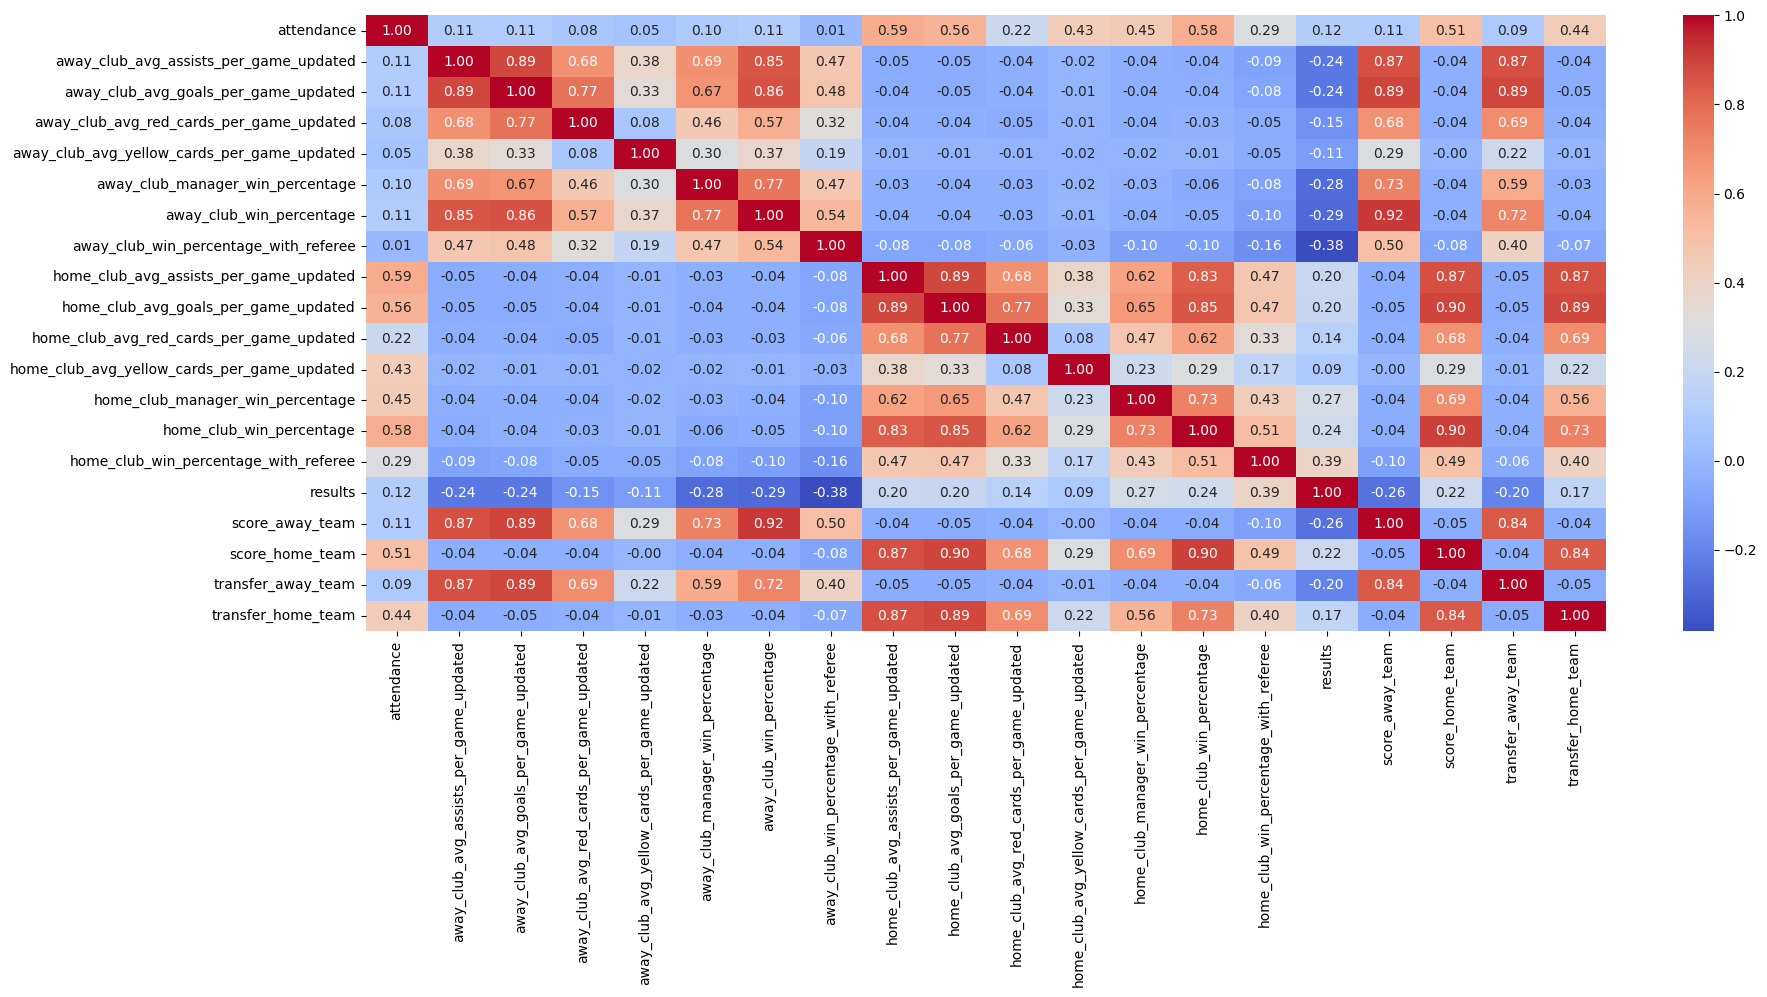

In [39]:
import seaborn as sns

def plot_correlation_matrix(data):
    correlation_matrix = data.corr()
    plt.figure(figsize=(20, 8))
    sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
    plt.show()
    
plot_correlation_matrix(data[data.columns.difference(['date'])])

We can now remove the most useless columns

In [40]:
correlation_matrix = data.corr()

columns_to_drop = correlation_matrix.columns[correlation_matrix['results'].abs() <= 0.2]
print(columns_to_drop)

data = data.drop(columns=columns_to_drop)
for col in columns_to_drop:
    features.remove(col) if col in features else None
features

ValueError: could not convert string to float: '2013-09-28'

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(data[features], data['results'], test_size=0.2, random_state=42)

In [ ]:
X_train = data[data['date'] < limit_date]
X_test = data[data['date'] >= limit_date]
y_train = X_train['results']
y_test = X_test['results']

X_train.drop(['date', 'results'], axis=1, inplace=True)
X_test.drop(['date', 'results'], axis=1, inplace=True)

X_train.head()

C:\Users\lorra\AppData\Local\Temp\ipykernel_7916\4190269897.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['date', 'results'], axis=1, inplace=True)
C:\Users\lorra\AppData\Local\Temp\ipykernel_7916\4190269897.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['date', 'results'], axis=1, inplace=True)


,attendance,home_club_win_percentage,away_club_win_percentage,home_club_manager_win_percentage,away_club_manager_win_percentage,home_club_win_percentage_with_referee,away_club_win_percentage_with_referee,score_away_team,score_home_team,transfer_home_team,transfer_away_team,home_club_avg_goals_per_game_updated,home_club_avg_assists_per_game_updated,home_club_avg_yellow_cards_per_game_updated,home_club_avg_red_cards_per_game_updated,away_club_avg_goals_per_game_updated,away_club_avg_assists_per_game_updated,away_club_avg_yellow_cards_per_game_updated,away_club_avg_red_cards_per_game_updated
0,0.836403,0.210477,-0.988550,0.765230,-0.955418,-0.742062,-0.142429,-0.835875,-0.152611,-0.299035,-0.535011,-0.484911,-0.429978,0.299390,-1.616598,-0.611881,-0.580392,-1.487994,2.231994
1,-1.020911,-0.751840,-0.792303,-0.363003,-0.335070,0.213617,-0.764538,-0.864978,-1.124269,-0.544110,-0.473467,-0.573619,-0.892441,-1.585813,-0.846678,-0.597832,-0.623449,-0.667448,-1.579174
2,-0.523070,-0.824290,0.662028,-1.588593,-0.174364,-0.820765,0.635207,0.030779,-1.172329,-0.496049,-0.474423,-0.689830,-0.852580,-1.843469,1.969510,0.116764,0.447897,1.509023,-0.736480
3,-0.641122,0.055677,-0.652127,-0.918579,-0.873590,0.348303,-0.764538,-1.124539,0.732274,0.640261,-0.544186,-0.088676,0.118301,-0.904232,-0.444756,-0.573423,-0.892057,-1.586295,-0.846627
4,-1.230985,-1.476335,0.213937,-1.913449,0.177054,0.536862,0.135298,0.734270,-0.989230,-0.544110,0.642739,-0.391421,-0.364037,-1.572798,1.027400,-0.087806,0.120125,-0.904540,-0.444792


## Model Selection and Training

We now are going to test different models to try to find the best one.
We choose a lot of classification models such as DecisionTree, RandomForest, and even some binary classifications models. Those models can only predict 1 or -1 values that correspond to wins and loses. In these models, no draws are possible, but the results can still be very instersting.

In [ ]:
from fonctions_tests import test_data, test_data_before_2023, get_accuracy_with_model

# Define the names of the classifications method
names = ["LogisticRegression Newton-cg",
         "LogisticRegression sag",
         "LogisticRegression saga",
         "LogisticRegression lbfgs",
         "NBayes",
         "LDA",
         "QDA",
         "KNN",
         "SVM linear",
         "SVM rbf",
         "SVM sigmoid",
         "RandomForest",
         "DecisionTree",
         "OneVsRestClassifier with SVM linear"]

# Define the classifiers
classifiers = [LogisticRegression(solver='newton-cg'),
               LogisticRegression(solver='sag'),
               LogisticRegression(solver='saga'),
               LogisticRegression(solver='lbfgs'),
               GaussianNB(),
               DA.LinearDiscriminantAnalysis(),
               DA.QuadraticDiscriminantAnalysis(),
               KNeighborsClassifier(n_neighbors=5),
               SVC(kernel='linear', C=1.0),
               SVC(kernel='rbf', gamma = 1e-4),
               SVC(kernel='sigmoid', gamma = 1e-4),
               RandomForestClassifier(),
               DecisionTreeClassifier(),
               OneVsRestClassifier(SVC(kernel='rbf'))]

scores = []

# Loop through all different classfication methods
for name, clf in zip(names, classifiers):
    
    clf.fit(X_train, y_train.values.ravel())
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    scores.append(accuracy)

    print("\tAccuracy with", name, ":", round(accuracy,3))

	Accuracy with LogisticRegression Newton-cg : 0.403
	Accuracy with LogisticRegression sag : 0.403
	Accuracy with LogisticRegression saga : 0.403
	Accuracy with LogisticRegression lbfgs : 0.403
	Accuracy with NBayes : 0.416
	Accuracy with LDA : 0.413
	Accuracy with QDA : 0.461


c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
found 0 physical cores < 1
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\lorra\AppData\Local\Programs\Python\Python311\Lib\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


	Accuracy with KNN : 0.382
	Accuracy with SVM linear : 0.413
	Accuracy with SVM rbf : 0.484
	Accuracy with SVM sigmoid : 0.458
	Accuracy with RandomForest : 0.413
	Accuracy with DecisionTree : 0.389
	Accuracy with OneVsRestClassifier with SVM linear : 0.437


ValueError: shape mismatch: objects cannot be broadcast to a single shape.  Mismatch is between arg 0 with shape (14,) and arg 1 with shape (0,).

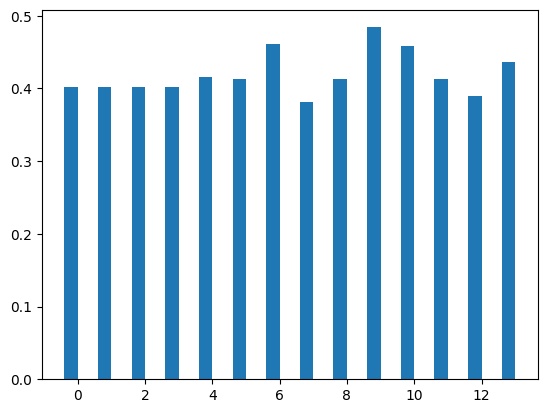

In [ ]:
X_axis = np.arange(len(names)) 

plt.bar(X_axis - 0.2, scores, 0.4, label = 'random data split')
  
plt.xticks(X_axis, names, rotation=45) 
plt.xlabel("models") 
plt.ylabel("accuracy") 
plt.title("Accuracy for every model") 
plt.legend()
plt.show()

We can see that the bests models are : SVM linear, Logistic regression, and LDA. Therefore, we'll try to optimize the best one : SVM Linear.

Let's now find some hyperparameters for this model ! 

In [ ]:
cv = 7
all_accuracies = {}
accuracies = []
sizes = [0.01, 0.1, 1, 10, 100]

for c in sizes:
    for i in range(cv):
        accuracy = test_data(data.iloc[np.random.choice(data.index, size=int(len(data) * 0.6), replace=False)], model=SVC(kernel='linear', C=c))
        if(c not in all_accuracies): all_accuracies[c] = []
        all_accuracies[c].append(accuracy)
        # print("\tAccuracy with ", name, " : ", round(accuracy,3))
    accuracies.append(np.mean(all_accuracies[c]))
    print('fini with c = ', c)

print("\nAccuracies : ", list(zip(sizes, accuracies)))

plt.plot(np.log10(sizes), accuracies)

In [ ]:
final_data = pd.read_csv("./data/matchs_2013_2022.csv")
matchs_2023 = pd.read_csv("./data/match_2023.csv")

final_data = pd.concat([final_data, matchs_2023])
final_data.tail()

,Unnamed: 0,game_id,season,round,date,home_club_id,away_club_id,home_club_goals,away_club_goals,home_club_position,...,stadium,attendance,referee,home_club_formation,away_club_formation,home_club_name,away_club_name,aggregate,competition_type,results
265,NaN,4094819,NaN,NaN,2024-03-31,738,969,NaN,NaN,NaN,...,Stade Océane,20556.0,Mathieu Vernice,NaN,NaN,Le Havre Athletic Club,Montpellier Hérault Sport Club,NaN,domestic_league,NaN
266,NaN,4094840,NaN,NaN,2024-04-21,415,244,NaN,NaN,NaN,...,Stadium Municipal,29809.0,Clément Turpin,NaN,NaN,Toulouse Football Club,Olympique de Marseille,NaN,domestic_league,NaN
267,NaN,4094776,NaN,NaN,2024-02-25,583,273,NaN,NaN,NaN,...,Parc des Princes,47874.0,Bastien Dechepy,NaN,NaN,Paris Saint-Germain Football Club,Stade Rennais Football Club,NaN,domestic_league,NaN
268,NaN,4094786,NaN,NaN,2024-03-03,415,417,NaN,NaN,NaN,...,Stadium Municipal,25507.0,Jérémie Pignard,NaN,NaN,Toulouse Football Club,Olympique Gymnaste Club Nice Côte d'Azur,NaN,domestic_league,NaN
269,NaN,4094777,NaN,NaN,2024-02-24,667,3911,NaN,NaN,NaN,...,Stade de la Meinau,25140.0,Jérôme Brisard,NaN,NaN,Racing Club de Strasbourg Alsace,Stade brestois 29,NaN,domestic_league,NaN


In [ ]:
limit_date = '2023-06-04'

get_club_win_percentage(final_data, limit_date)
get_win_percentage_of_manager(final_data, limit_date)
get_club_win_percentage_with_referee(final_data, limit_date)
add_club_scores(final_data, limit_date)
add_price_players(final_data)
add_updated_stats_players_team_mean(final_data, limit_date)

C:\Users\julie\AppData\Local\Temp\ipykernel_22468\956648943.py:17: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  lineups = pd.read_csv("data\game_lineups.csv", sep=",")


In [ ]:
features = []
features.append('attendance')
features.append('home_club_win_percentage')
features.append('away_club_win_percentage')
features.append('home_club_manager_win_percentage')
features.append('away_club_manager_win_percentage')
features.append('home_club_win_percentage_with_referee')
features.append('away_club_win_percentage_with_referee')
features.append('score_away_team')
features.append('score_home_team')
features.append('transfer_home_team')
features.append('transfer_away_team')
for club in ["home_club", "away_club"]:
    features.append(f'{club}_avg_goals_per_game_updated')
    features.append(f'{club}_avg_assists_per_game_updated')
    features.append(f'{club}_avg_yellow_cards_per_game_updated')
    features.append(f'{club}_avg_red_cards_per_game_updated')

In [ ]:
final_data = final_data[['date', 'results'] + features]

In [ ]:
final_data.to_csv("./data/test.csv", index=False)

In [ ]:
final_data[features] = SimpleImputer(strategy='mean').fit_transform(final_data[features])
final_data[features] = StandardScaler().fit_transform(final_data[features])

In [ ]:
final_data

,date,results,attendance,home_club_win_percentage,away_club_win_percentage,home_club_manager_win_percentage,away_club_manager_win_percentage,home_club_win_percentage_with_referee,away_club_win_percentage_with_referee,score_away_team,...,transfer_home_team,transfer_away_team,home_club_avg_goals_per_game_updated,home_club_avg_assists_per_game_updated,home_club_avg_yellow_cards_per_game_updated,home_club_avg_red_cards_per_game_updated,away_club_avg_goals_per_game_updated,away_club_avg_assists_per_game_updated,away_club_avg_yellow_cards_per_game_updated,away_club_avg_red_cards_per_game_updated
0,2013-09-28,0.0,0.798336,2.371420,0.306784,0.199096,0.553448,1.244440,-0.017145,-0.133556,...,-0.296305,-0.532790,-0.510659,0.388729,0.377935,-0.891532,-0.592185,-0.634336,-0.951287,1.516993
1,2013-10-19,-1.0,-1.037428,0.335552,-0.736125,0.574171,1.045514,-0.565153,-0.765426,-0.397360,...,-0.542588,-0.471201,-0.619291,-0.939099,-1.153801,-0.192882,-0.529180,-0.469019,-0.301979,-0.794445
2,2013-11-30,-1.0,-0.545362,-0.164486,0.142942,-0.378755,0.548030,-0.750134,0.980563,0.131494,...,-0.494290,-0.472157,-0.629041,-0.972437,-1.487964,1.770405,-0.392915,0.398708,2.255775,-0.204047
3,2014-01-18,0.0,-0.662045,-1.369033,0.291404,0.199096,1.045514,-0.873454,0.356995,-0.948443,...,0.647619,-0.541971,-0.642544,-1.027764,-2.027824,-0.431428,-0.618964,-0.938229,-1.154220,-0.192968
4,2014-02-08,1.0,-1.245064,0.657005,0.142942,0.199096,0.064457,0.359750,0.624238,0.517416,...,-0.542588,0.645823,-0.492996,-0.393919,-1.219627,0.887728,-0.642219,-1.026899,-2.029151,-0.431586
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,2024-03-31,NaN,-0.098302,0.335552,-0.267561,-1.354789,-0.167429,0.359750,-1.513708,-0.015719,...,-0.472632,-0.471201,-0.270580,-0.335035,-1.045881,0.126837,-0.270473,-0.173529,0.220128,0.941188
266,2024-04-21,NaN,0.629725,-0.922985,0.963949,0.199096,0.163373,-1.490056,-0.610610,1.445572,...,-0.533389,-0.334442,-0.493293,-1.022362,1.044846,-0.781117,0.530976,3.297514,-0.656343,0.487069
267,2024-02-25,NaN,2.051081,2.371420,0.142942,0.199096,0.064457,2.209556,0.824671,0.517416,...,-0.484132,-0.472157,2.232014,1.624889,0.956893,1.227560,-0.642219,-1.026899,-2.029151,-0.431586
268,2024-03-03,NaN,0.291243,-0.922985,0.291404,0.199096,1.045514,-0.256852,-0.110681,0.410718,...,0.103114,-0.299057,-0.493293,-1.022362,1.044846,-0.781117,-0.356597,-0.659117,-0.422679,-1.137779


In [ ]:
model = DA.LinearDiscriminantAnalysis()
# model = RandomForestClassifier()

X_train = final_data[final_data['date'] < limit_date]
X_test = final_data[final_data['date'] >= limit_date]
y_train = X_train['results']

X_train.drop(['date', 'results'], axis=1, inplace=True)
X_test.drop(['date', 'results'], axis=1, inplace=True)

model.fit(X_train, y_train.values.ravel())
y_pred = model.predict(X_test)

C:\Users\julie\AppData\Local\Temp\ipykernel_22468\2311181191.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train.drop(['date', 'results'], axis=1, inplace=True)
C:\Users\julie\AppData\Local\Temp\ipykernel_22468\2311181191.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test.drop(['date', 'results'], axis=1, inplace=True)


In [ ]:
y_train.value_counts(-1)
y_train.value_counts(0)
y_train.value_counts(1)

results
 1.0    0.441883
-1.0    0.294998
 0.0    0.263119
Name: proportion, dtype: float64

In [ ]:
y_pred

array([ 1.,  1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1.,  1., -1.,  1.,  1., -1.,  1.,
        1.,  1.,  1.,  0., -1.,  1., -1.,  1., -1.,  1., -1.,  1.,  1.,
        1.,  1., -1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,  1.,
       -1.,  1., -1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1., -1.,  1.,
       -1.,  1.,  1.,  1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,
        1., -1.,  1.,  1.,  1.,  1., -1., -1.,  1., -1.,  1.,  1.,  1.,
       -1.,  1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1.,
        1., -1.,  1.,  1., -1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1., -1., -1.,  1.,  1.,  1., -1